# Brain Tumor Classification Training - M2 MacBook Optimized
This notebook is optimized for M2 MacBooks using MPS (Metal Performance Shaders)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from copy import deepcopy
import matplotlib.pyplot as plt

# M2 MacBook: Use MPS if available, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: CUDA")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


In [2]:
# Updated data path for M2 MacBook
data_dir = "/path/to/project/data/Brain_Tumor_Dataset/Training"

# Transforms for Training & Validation
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [3]:
# Load Dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_tf)
class_names = full_dataset.classes
print("Classes:", class_names)
print("Total samples:", len(full_dataset))

# Split 80/20
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Override validation transform
val_dataset.dataset.transform = val_tf

# Data Loaders - optimized for M2
# Note: num_workers=0 is often better for MPS
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total samples: 5712
Training samples: 4570
Validation samples: 1142


In [4]:
num_classes = len(class_names)

# Pretrained ResNet18
base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Adjust head
base.fc = nn.Linear(base.fc.in_features, num_classes)

# Freeze all parameters
for p in base.parameters():
    p.requires_grad = False

# Unfreeze layer3, layer4 + fc
for name, p in base.named_parameters():
    if name.startswith("layer3") or name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True

model = base.to(device)

# Optimizer: different learning rates for different layers
params = [
    {"params": [p for n,p in model.named_parameters() if p.requires_grad and (n.startswith("layer3") or n.startswith("layer4"))], "lr": 3e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
]
optimizer = optim.Adam(params, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("Model ready for training on", device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to ~/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:19<00:00, 2.45MB/s]


Model ready for training on mps


In [5]:
import json

# Training Configuration
epochs = 30
patience = 5
best_val = float("inf")
bad = 0
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

# Setup output directories
output_dir = "../runs"
model_dir = "../models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

metrics_file = os.path.join(output_dir, "metrics.json")
with open(metrics_file, "w") as f:
    json.dump([], f)

# Model save path
model_save_path = os.path.join(model_dir, "brain_tumor_resnet18_m2.pt")

# Training Loop
for epoch in range(epochs):
    # --- Training ---
    model.train()
    tl, tc, tt = 0.0, 0, 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        tt += y.size(0)
    
    train_loss = tl / tt
    train_acc = 100 * tc / tt
    
    # --- Validation ---
    model.eval()
    vl, vc, vt = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            vt += y.size(0)
    
    val_loss = vl / vt
    val_acc = 100 * vc / vt
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    
    # Logging for metrics
    metrics = {
        "epoch": epoch + 1,
        "train_loss": float(train_loss),
        "val_loss": float(val_loss),
        "train_acc": float(train_acc),
        "val_acc": float(val_acc)
    }
    
    try:
        with open(metrics_file, "r") as f:
            content = f.read().strip()
            data = json.loads(content) if content else []
    except:
        data = []
    
    data.append(metrics)
    with open(metrics_file, "w") as f:
        json.dump(data, f, indent=2)
    
    # Print progress
    print(f"Epoch {epoch+1:02d} | Train {train_loss:.4f}, Acc {train_acc:.2f}% | "
          f"Val {val_loss:.4f}, Acc {val_acc:.2f}%")
    
    # Early Stopping
    if val_loss < best_val:
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, model_save_path)
        print(f"  → Model saved to {model_save_path}")
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

print("\nTraining complete!")
print(f"Best model saved to: {model_save_path}")

Epoch 01 | Train 0.2384, Acc 91.36% | Val 0.0987, Acc 96.50%
  → Model saved to ../models/brain_tumor_resnet18_m2.pt
Epoch 02 | Train 0.0707, Acc 97.55% | Val 0.0886, Acc 97.29%
  → Model saved to ../models/brain_tumor_resnet18_m2.pt
Epoch 03 | Train 0.0537, Acc 98.49% | Val 0.1063, Acc 96.67%
Epoch 04 | Train 0.0436, Acc 98.40% | Val 0.0772, Acc 96.94%
  → Model saved to ../models/brain_tumor_resnet18_m2.pt
Epoch 05 | Train 0.0170, Acc 99.47% | Val 0.0757, Acc 97.72%
  → Model saved to ../models/brain_tumor_resnet18_m2.pt
Epoch 06 | Train 0.0143, Acc 99.47% | Val 0.0834, Acc 97.64%
Epoch 07 | Train 0.0251, Acc 99.17% | Val 0.0829, Acc 97.37%
Epoch 08 | Train 0.0151, Acc 99.67% | Val 0.0720, Acc 98.07%
  → Model saved to ../models/brain_tumor_resnet18_m2.pt
Epoch 09 | Train 0.0226, Acc 99.23% | Val 0.2812, Acc 94.22%
Epoch 10 | Train 0.0198, Acc 99.43% | Val 0.0764, Acc 97.90%
Epoch 11 | Train 0.0060, Acc 99.87% | Val 0.0648, Acc 98.51%
  → Model saved to ../models/brain_tumor_resnet18

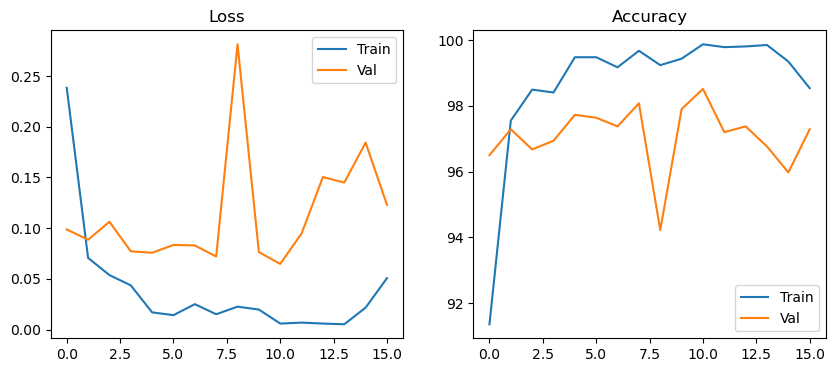

In [6]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.legend()
plt.title("Accuracy")
plt.show()

In [7]:
# Export final model
final_model_path = os.path.join(model_dir, "brain_tumor_resnet18_final.pt")
model.load_state_dict(torch.load(model_save_path, map_location=device))
torch.save(model.state_dict(), final_model_path)
print(f"Final model exported to: {final_model_path}")

# Optional: export as TorchScript
scripted_path = os.path.join(model_dir, "brain_tumor_resnet18_scripted.pt")
scripted = torch.jit.script(model)
scripted.save(scripted_path)
print(f"TorchScript model exported to: {scripted_path}")

Final model exported to: ../models/brain_tumor_resnet18_final.pt
TorchScript model exported to: ../models/brain_tumor_resnet18_scripted.pt
